<a href="https://colab.research.google.com/github/anni1st/Anomaly-Detection-VM-/blob/main/anomaly_detection_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore")

In [33]:
from google.colab import files
uploaded = files.upload()


Saving memory_data_fix.csv to memory_data_fix.csv


In [61]:
df = pd.read_csv('memory_data_fix.csv')
df

,timestamp,value
0,2020-01-03 00:00:00,59.01
1,2020-01-03 00:05:00,63.21
2,2020-01-03 00:10:00,59.57
3,2020-01-03 00:15:00,61.18
4,2020-01-03 00:20:00,60.09
...,...,...
995,2020-01-06 10:55:00,58.72
996,2020-01-06 11:00:00,60.92
997,2020-01-06 11:05:00,61.89
998,2020-01-06 11:10:00,57.62


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1000 non-null   object 
 1   value      1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [63]:
df.describe()

,value
count,1000.000000
mean,60.499320
std,1.620779
min,57.610000
25%,59.060000
50%,60.475000
75%,61.860000
max,63.350000


In [64]:
round(df.describe(),2)

,value
count,1000.00
mean,60.50
std,1.62
min,57.61
25%,59.06
50%,60.47
75%,61.86
max,63.35


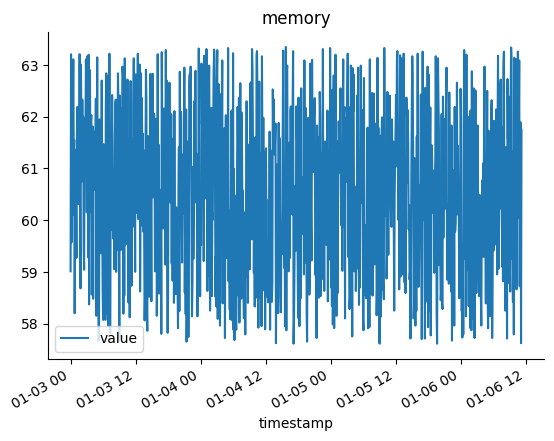

In [65]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x='timestamp', y='value', title='memory')
plt.gca().spines[['top', 'right']].set_visible(False)

In [67]:
#feature engineering

df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 6) & (df['hours'] <= 18)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [68]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

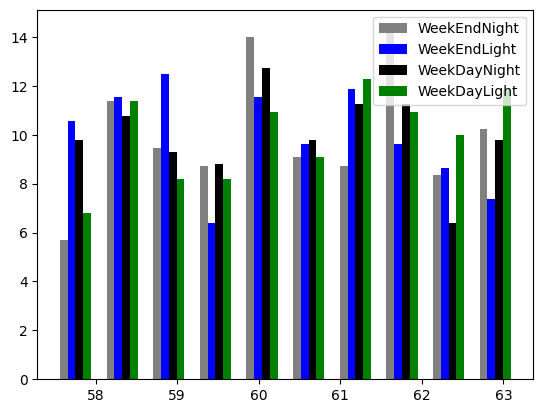

In [69]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='grey', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='blue', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='black', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='green', label ='WeekDayLight')

plt.legend()
plt.show()

In [70]:
#standardize

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

In [74]:
#train one class svm

outliers_fraction = 0.01
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)

df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    987
1     13
Name: anomaly26, dtype: int64


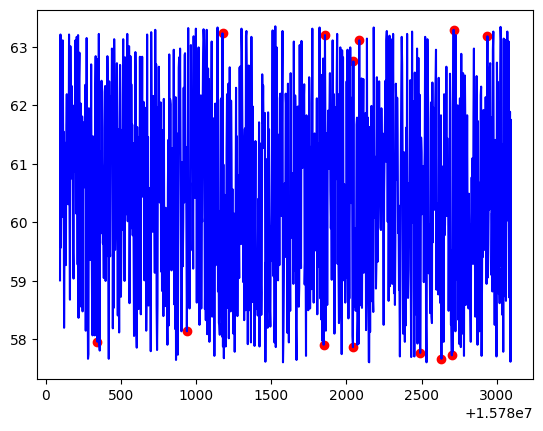

In [78]:
# visualisation of anomaly throughout time

fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()